<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/3_First_order_methods/3_7_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 3: First order methods

# Two Natural Weaknesses of Gradient Descent

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_3_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_library
    else:
        print('chapter_3_library already cloned!')

    # clone images
    if not Path('chapter_3_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_images
    else:
        print('chapter_3_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_3_library')
sys.path.append('./chapter_3_images') 

# import section helper
import section_3_7_helpers
static_plotter = section_3_7_helpers.static_visualizer()
demo = section_3_7_helpers.grad_descent_visualizer()

# image paths
image_path_1 = 'chapter_3_images/direction_magnitude.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=b7852127dd962cdd1682075e9205f06bd96fde12f88a45c65b0a6da63db7bb0e
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_3_library'...
done.
Cloning into 'chapter_3_images'...
done.


As we saw in the previous Section, gradient descent is a local optimization scheme that employs the negative gradient at each step.  The fact that calculus provides us with a true descent direction in the form of the negative gradient direction, combined with the fact that gradients are often cheap to compute (whether or not one uses an Automatic Differentiator), means that we need not search for a reasonable descent direction at each step of the method as we needed to do with the zero order methods detailed in the previous Chapter.  This is extremely advantageous.  

However the negative gradient is not without its weaknesses as a descent direction, and in this Section we outline two significant problems with it that can arise in practice.  Like any *vector* the negative gradient always consists fundamentally of a *direction* and a *magnitude*.  Depending on the function being minimized either one of these attributes - or both - can present challenges when using the negative gradient as a descent direction.  

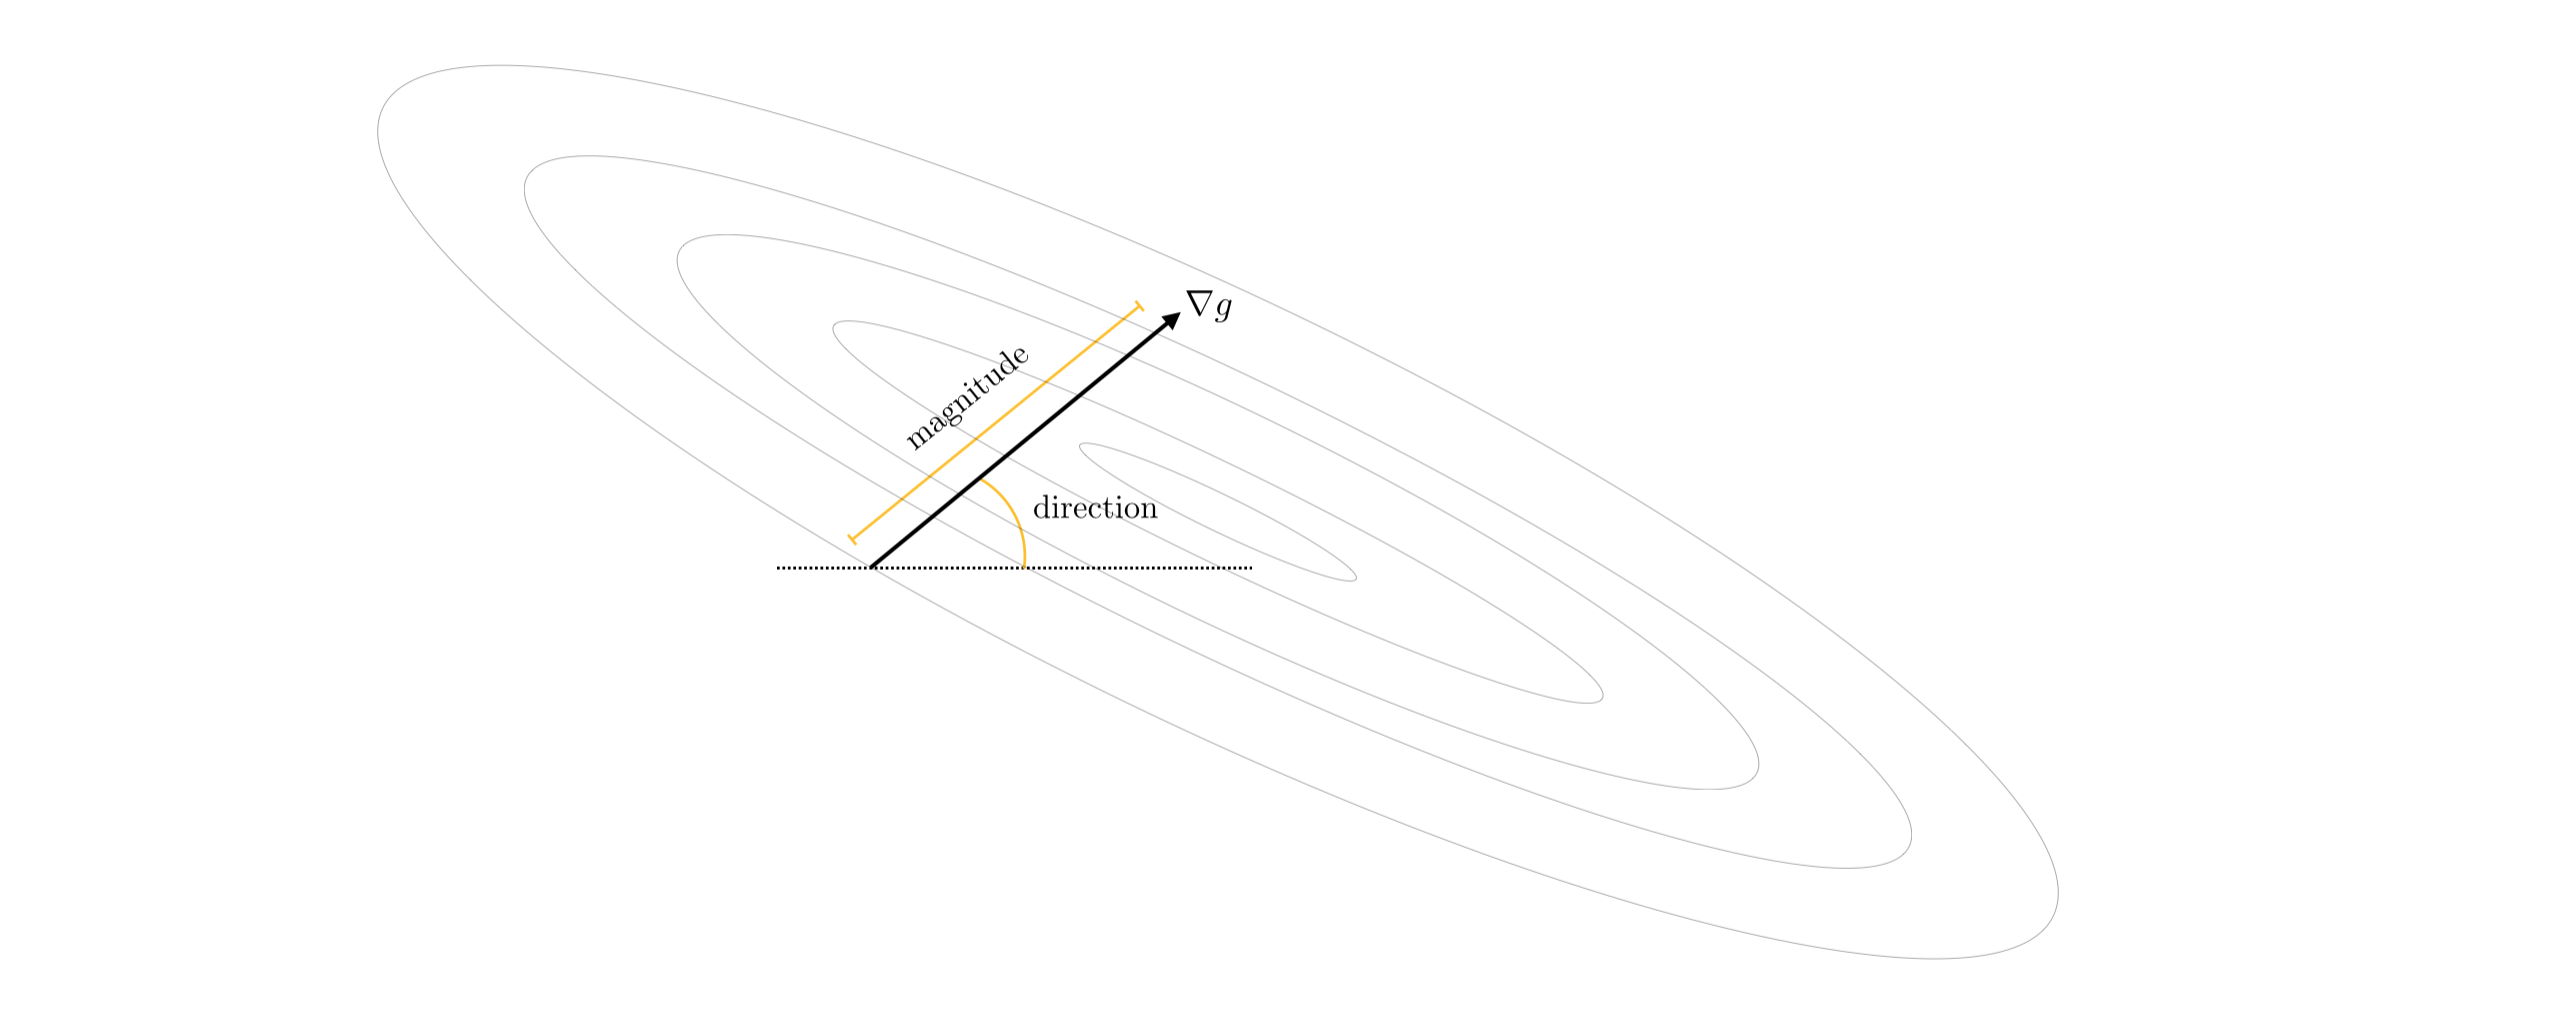

In [3]:
Image(image_path_1, width=1000)

The *direction* of the negative gradient can *rapidly oscillate* or *zig-zag* during a run of gradient descent, often producing *zig-zagging* steps that take considerable time to reach a near mininum point.  The *magnitude* of the negative gradient can *vanish rapidly* near stationary points, leading gradient descent to slowly crawl near minima and saddle points.  This too can slow down gradient descent's progress progress near stationary points.  These two problems - while not present when minimizing every single function - do present themselves in machine learning because many of the functions we aim to minimize have *long narrow valleys*, long flat areas where the contours of a function become increasingly parallel. 

In [4]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

##   The (negative) gradient direction points perpendicular to the contours of any function

A fundamental property of the (negative) gradient direction is that it always points perpendicular the contours of a function.  This statement is universally true - and holds for *any* function and at *all* of its inputs.

> A fundamental property of the (negative) gradient direction is that it always points perpendicular the contours of a function.  This statement is universally true - and holds for *any* function and at *all* of its inputs.

We illustrate this fact via several examples below, where we show the *contour plot* of several functions along with the negative gradient direction computed and drawn at several points.  What we will see is that a gradient ascent / descent direction at an input $\mathbf{w}^{\star}$ is always perpendicular to the contour $g\left(\mathbf{w}^{\star}\right) = c$.  This statement can be rigorously (mathematically) proven to be true as well, which we do after the examples.

#### <span style="color:#a50e3e;">Example 1. </span>  Gradient descent directions on the contour plot of a quadratic function

Below we show the contour plot of a quadratic function 

\begin{equation}
g\left(\mathbf{w}\right) = w_0^2 + w_1^2 + 2
\end{equation}

along with the gradient descent directions defined at three random points.  The contour plot is colored *blue* - with darker regions indicating where the function takes on larger values, and lighter regions where it takes on lower values.  Each of the points we choose are highlighted in a unique color, with the contour on which they sit on the function colored in the same manner.  The *descent* direction defined by the gradient at each point is drawn as an arrow and the tangent line to the contour at each input is also drawn (in both instances colored the same as their respective point).

In each instance we can see how the gradient descent direction lies perpendicular to the contour it lies on - in particular being perpendicular to the tangent line at each point on the contour.  Since the gradient direction in each instance is the normal vector for this tangent line they can each be written as

\begin{equation}
\nabla g\left(\mathbf{w}\right)^T \left(\mathbf{w} - \mathbf{v}\right) = 0.
\end{equation}


Because the gradient ascent directions will simply point in the opposite direction as the descent directions shown here, they too will be perpendicular to the contours.

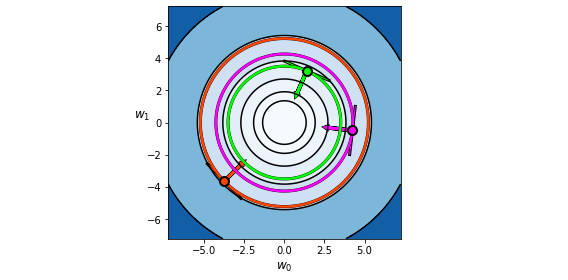

In [5]:
# function to plot
g = lambda w: w[0]**2 + w[1]**2 + 2

# random points at which to compute the gradient
pts = np.array([[ 4.24698761,  1.39640246, -3.75877989],
               [-0.49560712,  3.22926095, -3.65478083]])

# produce contour plot with gradients
section_3_7_helpers.illustrate_gradients(g,pts);

#### <span style="color:#a50e3e;">Example 2. </span>  Gradient descent directions on the contour plot of a wavy function

Here we show the contour plot and gradient descent directions in the same manner as the previous example, only for the wavy function

\begin{equation}
g\left(\mathbf{w}\right) = w_0^2 + w_1^2 + 2\text{sin}\left(1.5\left(w_0 + w_1\right)\right)^2 + 2.
\end{equation}

Here we have taken the quadratic in the previous example and added a three dimensional sinusoid to it, creating a highly non-convex function.  However - evaluating the gradient at the same three random points - we still see that each gradient descent direction is perpendicular to its corresponding contour.

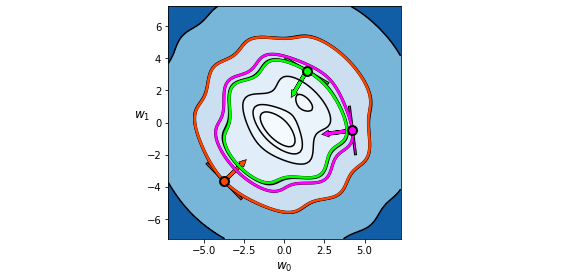

In [6]:
# function to plot
g = lambda w: w[0]**2 + w[1]**2 + 2*np.sin(1.5*(w[0] + w[1])) + 2

# points at which to compute the gradient
pts = np.array([[ 4.24698761,  1.39640246, -3.75877989],
               [-0.49560712,  3.22926095, -3.65478083]])

# produce contour plot with gradients
section_3_7_helpers.illustrate_gradients(g,pts)

#### <span style="color:#a50e3e;">Example 3. </span>  Gradient descent directions on the contour plot of a standard non-convex test function

Finally we show the same sort of plot as in the previous example using the function

\begin{equation}
g\left(\mathbf{w}\right) = \left(w_0^2 + w_1 - 11 \right)^2  + \left( w_0 + w_1^2 - 6 \right)^2
\end{equation}

which is commonly used as a simple test for optimization algorithms.  Here we evaluate gradient at three random points and illustrate the corresponding descent direction in each instance.  Once again, we see that the gradient directions are perpendicular to their respective contours.

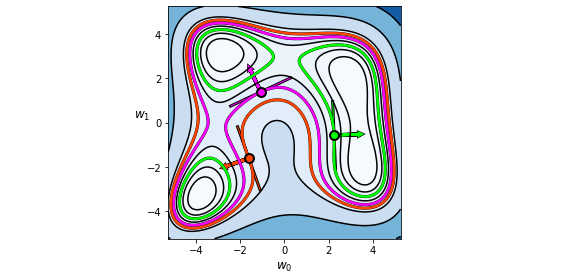

In [7]:
# function to plot
g = lambda w: (w[0]**2 + w[1] - 11)**2 + (w[0] + w[1]**2 - 7)**2

# points at which to compute the gradient
pts = np.array([[ 2.2430266 , -1.06962305, -1.60668751],
               [-0.57717812,  1.38128471, -1.61134124]])

# produce contour plot with gradients
section_3_7_helpers.illustrate_gradients(g,pts)

---

Having seen a number of examples of this phenomenon, let us quickly confirm via rigorous mathematical reasoning that indeed the (negative) gradient direction always points perpendicular to the contours of any function.

If we suppose $g\left(\mathbf{w}\right)$ is a differentiable function and $\mathbf{a}$ is some input point, then $\mathbf{a}$ lies on the contour defined by all those points where $g\left(\mathbf{w}\right) = g\left(\mathbf{a}\right) = c$ for some constant $c$.  If we take another point from this contour $\mathbf{b}$ very close to $\mathbf{a}$ then the vector $\mathbf{a} - \mathbf{b}$ is essentially perpendicular to the gradient $\nabla g\left(\mathbf{a}\right)$ since $\nabla g\left(\mathbf{a}\right)^T\left(\mathbf{a} - \mathbf{b}\right) = 0$ essentially defines the line in the input space whose normal vector is precisely $\nabla g\left(\mathbf{a}\right)$.  So indeed both the ascent and descent directions defined by the gradient (i.e., the positive and negative gradient directions) of $g$ at $\mathbf{a}$ are perpendicular to the contour there.  And since $\mathbf{a}$ was any arbitrary input of $g$, the same argument holds for each of its inputs.

##  The 'zig-zagging' behavior of gradient descent

In practice the fact that the negative gradient *always points perpendicular to the contour of a function* can - depending on the function being minimized - make the negative gradient direction *oscillate rapidly* or *zig-zag* during a run of gradient descent.  This in turn can cause zig-zagging behavior in the gradient descent steps themselves.  *Too much* zig-zagging slows minimization progress and - when it occurs - many gradient descent steps are required to adequately minimize a function.   We illustrate this phenomenon below using a set of simple examples.  

#### <span style="color:#a50e3e;">Example 4. </span>  Zig-zagging behavior of gradient descent on three simple quadratic functions

We illustrate the zig-zag behavior of gradient descent with three $N = 2$ dimensional quadratic that take the general form

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}.
\end{equation}

The constants $a$ and $\mathbf{b}$ in of three quadratics are set to zero, and the matrix $\mathbf{C}$ in each case is set as follows


- the first quadratic (shown in the top panel below) has $\mathbf{C} = \begin{bmatrix} 0.5\,\,0 \\ 0 \,\, 12\end{bmatrix}$ 



- the second quadratic (shown in the middle panel below) has $\mathbf{C} = \begin{bmatrix} 0.1\,\,0 \\ 0 \,\, 12\end{bmatrix}$ 



- the third quadratic (shown in the bottom panel below) has $\mathbf{C} = \begin{bmatrix} 0.01\,\,0 \\ 0 \,\, 12\end{bmatrix}$ 



In other words, the three quadratics differ only in the value we assign to the top left entry of their $\mathbf{C}$ matrix.  While all three quadratics have the same global minimum at the origin $\mathbf{w} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ where $g\left(\mathbf{w}\right) = 0$, as we change this single value of $\mathbf{C}$ we elongate the contours significantly along the horizontal axis so that in the third quadratic the contours are almost completely paralell to each other near our initialization (an example of a long narrow valley).

We then make a run of 25 gradient descent steps to minimize each, and with each we use the same initialization at $\mathbf{w}^0 = \begin{bmatrix} 10 \\ 1 \end{bmatrix}$  and steplength / learning rate value $\alpha = 10^{-1}$.  In each case the weights found at each step are colored green (at the start of the run) to red (as we reach the maximum number of iterations is reached), with arrows connecting each step to the one that follows.  Here we can visibly see - in each case, but increasingly from the first to third example - the zig-zagging behavior of gradient descent very clearly.  Indeed not much progress is made with the third quadratic at all due to the large amount of zig-zagging.

We can also see the cause of this zig-zagging: the negative gradient direction constantly points perpindicular to the contours of the function (this can be especially seen in the third case).  This zig-zagging clearly slows down the progress of the algorithm as it aims to find the mininum of each quadratic (which again in all three cases is located at the origin where the quadratics take on a value of zero).

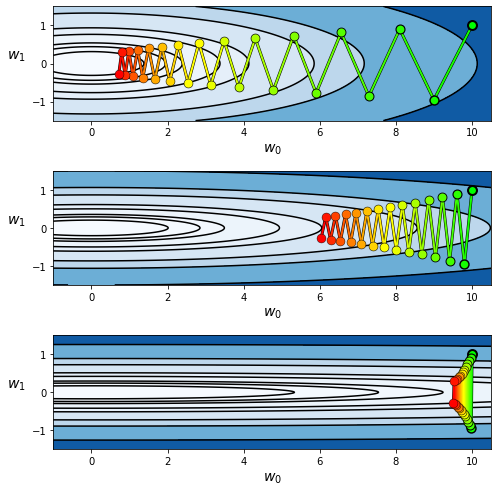

In [8]:
#### minimize first quadratic ####
# define constants for a N=2 input quadratic
a1 = 0
b1 = 0*np.ones((2,1))
C1 = np.array([[0.5,0],[0,9.75]])

# a quadratic function defined using the constants above
g1 = lambda w: (a1 + np.dot(b1.T,w) + np.dot(np.dot(w.T,C1),w))[0]

# run gradient descent 
w = np.array([10.0,1.0]); max_its = 25; alpha_choice = 10**(-1);
weight_history_1,cost_history_1 = gradient_descent(g1,alpha_choice,max_its,w)

#### minimize second quadratic ####
# define constants for a N=2 input quadratic
a2 = 0
b2 = 0*np.ones((2,1))
C2 = np.array([[0.1,0],[0,9.75]])

# a quadratic function defined using the constants above
g2 = lambda w: (a2 + np.dot(b2.T,w) + np.dot(np.dot(w.T,C2),w))[0]

# run gradient descent 
weight_history_2,cost_history_2 = gradient_descent(g2,alpha_choice,max_its,w)

#### minimize third quadratic ####
# define constants for a N=2 input quadratic
a3 = 0
b3 = 0*np.ones((2,1))
C3 = np.array([[0.01,0],[0,9.75]])

# a quadratic function defined using the constants above
g3 = lambda w: (a3 + np.dot(b3.T,w) + np.dot(np.dot(w.T,C3),w))[0]

# run gradient descent 
weight_history_3,cost_history_3 = gradient_descent(g3,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
histories = [weight_history_1,weight_history_2,weight_history_3]
gs = [g1,g2,g3]
static_plotter.two_input_contour_vert_plots(gs,histories,num_contours = 20,xmin = -1,xmax = 10.5,ymin = -1.5,ymax = 1.5)

Indeed the zig-zagging behavior of gradient descent in each of these cases above is completely due to the *rapid change in negative gradient direction* during each run, or the zig-zag of the negative gradient direction itself.  We can see this rapid change in direction by plotting *just the descent directions themselves*.  Below we plot the descent direction from the first $9$ steps of gradient descent performed on the first quadratic shown above.  Each negative gradient descent direction is shown as unit-length arrow stemming from the origin (they are vectors after all), and is colored green (for the first steps of each run) to red (when the run halted).  At each step the preceeding descent directions are shown faded for visual comparison.  Even though the run on the first quadratic above showed the least amount of zig-zagging of the three examples shown above, nonetheless the descent directions themselves oscillate wildly.

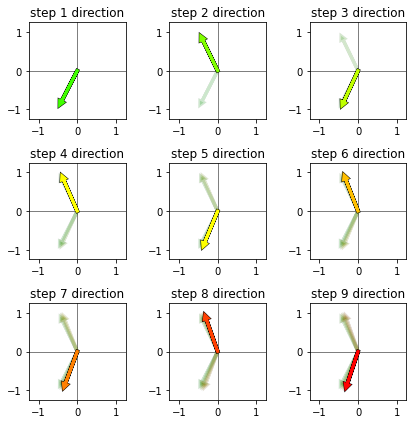

In [9]:
static_plotter.plot_grad_directions_v2(weight_history_1)

Below we show the same kind of plot for the first $9$ steps of the third run of gradient descent shown above.  Here we can see that the subsequent descent directions point in the exact opposite directions - which of course creates massive zig-zagging in the descent steps themselves.

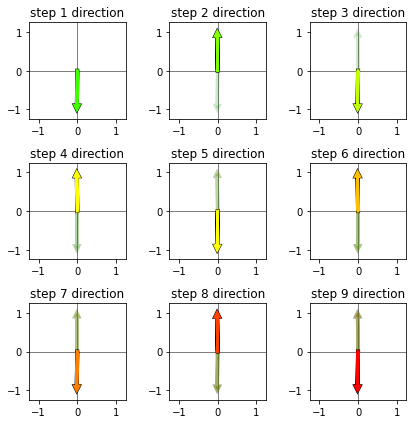

In [10]:
static_plotter.plot_grad_directions_v2(weight_history_3)

The slow convergence caused by zig-zagging in each case can be seen in the slow decrease of the cost function history associated with each run shown above.  We plot these below with the first run in black, the second in pink, and the third in blue.

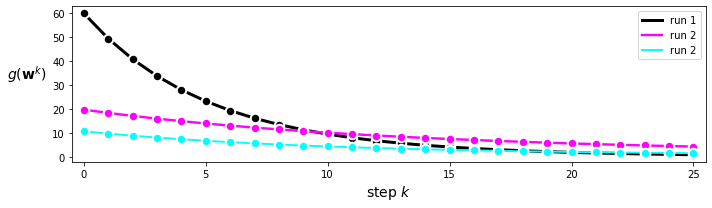

In [11]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2,cost_history_3],start = 0,points = True,labels = ['run 1','run 2'])

It is the true that we can ameilorate this zig-zagging behavior by *reducing the steplength value*, as shown in the figure below where we re-run gradient descent on the first quadratic using a smaller value for $\alpha$.  However this does not solve the underlying problem that zig-zagging produces - which is slow convergence.  Typically in order to ameliorate or even eliminate zig-zagging this way requires a very small steplength, which leads back to the fundamental problem of slow convergence.  This is illustrated in the run below where zig-zagging has been all but eliminated, but progress is very slow.

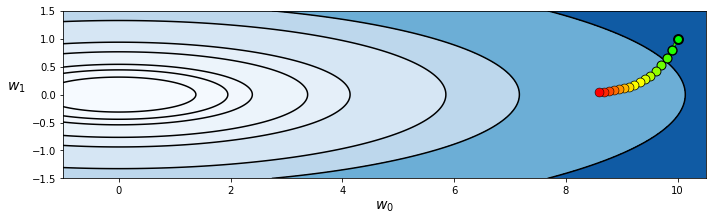

In [12]:
a1 = 0
b1 = 0*np.ones((2,1))
C1 = np.array([[0.5,0],[0,9.75]])

# a quadratic function defined using the constants above
g1 = lambda w: (a1 + np.dot(b1.T,w) + np.dot(np.dot(w.T,C1),w))[0]

# run gradient descent 
w = np.array([10.0,1.0]); max_its = 15; alpha_choice = 10**(-2);
weight_history_1,cost_history_1 = gradient_descent(g1,alpha_choice,max_its,w)

# plot contour and weight history
static_plotter.two_input_contour_plot(g1,weight_history_1,show_original = False,num_contours = 20,xmin = -1,xmax = 10.5,ymin = -1.5,ymax = 1.5)

##  The (negative) gradient magnitude vanishes near stationary points

As we know from the *first order condition for optimality* discussed in [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html), the (negative) gradient vanishes at stationary points.  That is if $\mathbf{w}$ is a minimum, maximum, or saddle point then we know that $\nabla g\left(\mathbf{w}\right) = \mathbf{0}$.  This of course means the same thing for the negative gradient as well, and means that the direction provided by the negative gradient is precisely the zero vector (or origin).  Notice that this also means that *the magnitude of the gradient vanishes at stationary points*, that is $\Vert \nabla g \left(\mathbf{w}\right) \Vert_2 = 0$.  By extension, the (negative) gradient at points *near a stationary point have non-zero direction but vanishing magnitude* i.e., $\Vert \nabla g \left(\mathbf{w}\right) \Vert_2 \approx 0$.

Indeed in our discussion of gradient descent in the previous Section we discussed how this very fact - the diminishing magnitude of the gradient near stationary points - can be used as an ideal stopping condition (as opposed to the simpler and more commonly used maximium iteration count).

##  The slow-crawling behavior of gradient descent

The vanishing behavior of the negative gradient magnitude near stationary points has a natural consequence for gradient descent steps - they progress very slowly, or 'crawl', near stationary points.  This occurs because *unlike* the zero order methods discussed in the previous Chapter, *the distance traveled during each step of gradient descent is not completely determined by the steplength / learning rate value $\alpha$*.  Indeed with with the general local optimization step

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k-1}
\end{equation}

we saw that if $\mathbf{d}^{k-1}$ is a *unit length descent direction found by any zero order search approach* that the distance traveled with this step equals precisely the steplength value $\alpha$ since

\begin{equation}
\left\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \right\Vert_2 = \left\Vert \left(\mathbf{w}^{k-1} + \alpha \mathbf{d}^{k-1}\right) - \mathbf{w}^{k-1} \right\Vert_2 = \alpha \left\Vert \mathbf{d}^{k-1} \right\Vert_2 = \alpha.
\end{equation}

Again here the key assumption made was that our descent direction $\mathbf{d}^{k-1}$ had *unit length*. 

However if we do the same simple analysis on our gradient descent step where our descent direction $\mathbf{d}^{k-1} = -\nabla g\left(\mathbf{w}^{k-1}\right)$ we can see that because our descent direction is *not*  guaranteed to have unit length we travel a distance *proportional to the magnitude of the gradient* = $\alpha \left\Vert \nabla g\left(\mathbf{w}^{k-1}\right) \right\Vert_2$ since

\begin{equation}
\left\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \right\Vert_2 =  \left\Vert \left(\mathbf{w}^{k-1} - \alpha\nabla g\left(\mathbf{w}^{k-1}\right) \right) - \mathbf{w}^{k-1} \right\Vert_2  = \alpha \left\Vert \nabla g\left(\mathbf{w}^{k-1}\right) \right\Vert_2.
\end{equation}

In other words, the length of the $k^{th}$ step is equal to the value of $\alpha$ *times* the magnitude of the descent direction.  This differs from the simple zero-order search methods described in the previous Chapter where - by choice - we used descent directions of unit length, and hence the length of each step was completely controlled by the steplength parameter $\alpha$.  

The consequences of this are fairly easy to unwravel.  Since the magnitude of the gradient $\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right) \right\Vert_2.$ is *large* far from stationary points gradient descent takes *large* steps.  Since we often randomly initialize gradient descent in practice our initial point will often lie far away from a stationary point, and so the first few steps will be large and therefore make significant progress towards minimization.  Conversely when approaching a stationary point the magnitude of the gradient is *small* and so the length traveled by a gradient descent step is also *small*.  This means that gradient descent steps make little progress towards minimization when near a stationary point and so - depending on the function - many of them may be required to complete minimization.

In short, the fact that the length of each step of gradient descent is proportional to the magnitude of the gradient means that often gradient descent starts off making significant progress but slows down significantly near minima and saddle points - a behavior we refer to as 'slow crawling'.  For particular functions this 'slow crawling' behavior can not only mean that many steps are required to achieve adequate minimization, but can also  lead gradient descent to completely near saddle points of non-convex functions.

#### <span style="color:#a50e3e;">Example 5. </span>  Slow-crawling behavior of gradient descent near the minimum of a function

Below we show another example run of gradient descent using a function 

\begin{equation}
g(w) = w^4 + 0.1
\end{equation}

whose minimum is at the origin $w = 0$.  This example further illustrates the effect of gradient magnitude on the length of each gradient descent step.  In particular showing how steps can be quite large far from a stationary point, but then get very small and crawls as we get closer and closer to the minimum of this function.  Note here that we have initialized and set the steplength parameter $\alpha = 10^{-1}$ for $10$ steps to exaggerate this behavior, so that it is more clearly visible (the original function is shown in the left panel, and with steps in the right panel colored from green = start to red = final step).   The fact that gradient descent crawls as it approaches the minimum of this function is quite natural - because the magnitude of the gradient vanishes here - but this prevents the algorithm from making quick progress.  This crawling behavior will obviously be mirrored in the cost function history plot of this run of gradient descent.

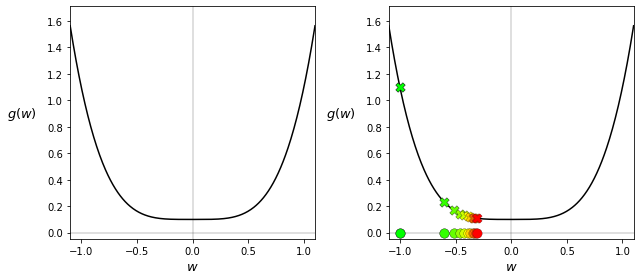

In [13]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**4 + 0.1

# run gradient descent 
w = -1.0; max_its = 10; alpha_choice = 10**(-1);
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history],[cost_history],wmin = -1.1,wmax = 1.1)

#### <span style="color:#a50e3e;">Example 6. </span> Slow-crawling behavior of gradient descent near saddle points

We illustrate the crawling issue of gradient descent near saddle points using the non-convex function

\begin{equation}
g(w) = \text{maximum}(0,(3w - 2.3)^3 + 1)^2 + \text{maximum}(0,(-3w + 0.7)^3 + 1)^2
\end{equation}

which has a minimum at $w= \frac{1}{2}$ and saddle points at $w = \frac{7}{30}$ and $w = \frac{23}{30}$.  We make a run of gradient descent on this function using $50$ steps with $\alpha = 10^{-2}$, initialized such that it approaches one of these saddle points and so slows to a halt.  

We can see how the gradient descent steps - plotted on top of the function in the right panel - halt near the left-most saddle point due to the settings (initialization and steplength parameter) chosen for this run.  The fact that gradient descent crawls as it approaches this saddle point is quite natural - because the magnitude of the gradient vanishes here - but this prevents the algorithm from finding the global mininum.

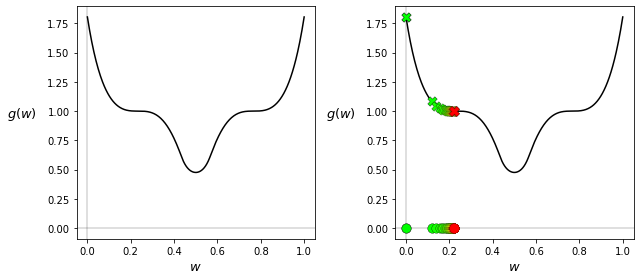

In [14]:
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
# draw function and gradient descent run
demo.draw_2d(g=g, w_inits = [0],steplength = 0.01,max_its = 50,version = 'unnormalized',wmin = 0,wmax = 1.0)

#### <span style="color:#a50e3e;">Example 7. </span> Slow-crawling behavior of gradient descent in large flat regions of a function

As another example, we attempt to minimize the function

\begin{equation}
g(w_0,w_1) = \text{tanh}(4w_0 + 4w_1) + \text{max}(1,0.4w_0^2) + 1
\end{equation}

via gradient descent starting at the point $\mathbf{w}^0 = \begin{bmatrix} 2 \\ 2 \end{bmatrix}$.  As can be seen in the figure below - where botht the surface (left panel) and contour plot (right panel) are plotted - this initialization lies in a long narrow valley of this non-convex function.  The magnitude of the gradient being almost zero here, we cannot make much progress employing $1000$ steps of gradient descent with a steplength $\alpha = 10^{-1}$ which was the largest fixed steplength of the form $10^{-\gamma}$ found that did not to cause divergence.  

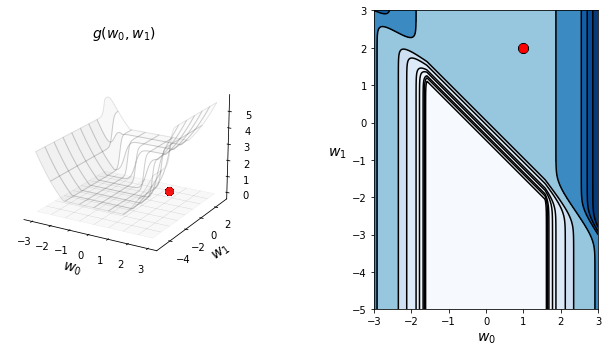

In [15]:
# define function
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1
w = np.array([1.0,2.0]); max_its = 1000; alpha_choice = 10**(-1);
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w)

# plot contour and weight history
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,300],num_contours = 20,xmin = -3,xmax = 3,ymin = -5,ymax = 3)